## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/usr/local/google/home/carverforbes/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the Import Statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
import datetime
import gc

from absl import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


## Feature Extraction
Configure the following parameters to extract the desired features from a specified csv file to a specific destination directory.

In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_50_50'
notebook = 'training_mfcc_cnn'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate']
features_to_extract = ['mfcc']
redo = False

In [5]:
def dataframe_to_csv(dataframe, dest_path):
    start_time = datetime.datetime.now()
    stop = dataframe.index.stop
    begin = 0
    end = 100
    count = 0
    while end < stop + 100:
        df = dataframe.iloc[begin:end, :].copy()
        for column in df.columns:
            for i in range(df[column].size):
                i = i + count * 100
                if isinstance(df[column][i], np.ndarray):
                    df[column][i] = df[column][i].tolist()
        if count == 0:
            df.to_csv(dest_path, index=False, header=True)
        else:
            df.to_csv(dest_path, mode='a', index=False, header=True)
        begin += 100
        end += 100
        count += 1
    end_time = datetime.datetime.now()
    function_duration = end_time - start_time
    
        
    print('Created the csv file at the destination path in {} seconds.'.format(
        function_duration))

In [6]:
def csv_to_dataframe(csv_path):
    df = pd.read_csv(csv_path)
    for column in df.columns:
        for i in range(df[column].size):
            if isinstance(df[column][i], str):
                temp = df[column][i][1:-1]
                temp = temp.replace(',', ' ').split(']')
                new_list = []
                for item in temp:
                    if item == '':
                        continue
                    item = item.replace('[', '').strip().split()
                    item = [float(num) for num in item]
                    arr = np.array(item)
                    new_list.append(arr)
                new_arr = np.array(new_list)
                df[column][i] = new_arr
    return df

In [ ]:
# Import the dataset as a pandas DataFrame object.
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, redo)

In [8]:
# print the first 5 rows of the dataframe.
df.head()

,label,mfcc
0,1,"[[-303.27164, -310.85724, -324.51694, -325.635..."
1,1,"[[-282.00607, -289.7648, -299.44608, -298.7115..."
2,1,"[[-601.3228, -601.3228, -601.3228, -601.3228, ..."
3,1,"[[-244.3129, -188.5689, -145.10178, -155.65407..."
4,0,"[[-305.8128, -300.2478, -302.55612, -301.78333..."


## Data Preprocessing

Enter your data preprocessing here.

In [9]:
def fix_dataframe(dataframe):
    # temp bug fix for rows with None features
    # and rows with different number of elements per frame
    bad_rows = []
    for i in dataframe.index:
        if dataframe.mfcc[i] is None:
            bad_rows.append(i)
        elif dataframe.mfcc[i][0] is None:
            bad_rows.append(i)
        elif len(dataframe.mfcc[i]) != 20:
            bad_rows.append(i)
        elif len(dataframe.mfcc[i][0]) != 431:
            bad_rows.append(i)
    new_dataframe = dataframe.drop(bad_rows)
    return new_dataframe

In [10]:
def shuffle_dataframe(dataframe):
    # Shuffle the dataset/dataframe.
    dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
    return dataframe

In [11]:
def dataframe_to_x_y(dataframe):
    X = np.array(dataframe.mfcc.tolist(), dtype=object)
    y = np.array(dataframe.label.tolist())
    
    # Convert arrays of objects to arrays of floats.
    X = tf.keras.backend.cast_to_floatx(X)
    y = tf.keras.backend.cast_to_floatx(y)
    return X, y

In [12]:
def data_preprocessing(dataframe):
    print('Dropping incongruent features from dataframe')
    dataframe = fix_dataframe(dataframe)
    print('shuffling dataframe')
    dataframe = shuffle_dataframe(dataframe)
    print('Getting X, y out of dataframe')
    X, y = dataframe_to_x_y(dataframe)
    x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)
    return x_train, y_train, x_val, y_val

In [13]:
x_train, y_train, x_val, y_val = data_preprocessing(df)

Dropping incongruent features from dataframe
shuffling dataframe
Getting X, y out of dataframe


## Building and Training Neural Network

In [14]:
def make_dir(path):
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            return False
    return True

In [15]:
# Define the plotting function.
def plot_curve(epochs, hist, dest_path, notebook_filename, dataset_filename, list_of_metrics, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    make_dir(dest_path)    
    path = os.path.join(dest_path, notebook_filename)
    make_dir(path)
    path = os.path.join(path, dataset_filename)
    make_dir(path)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    filename = '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Training 1

In [16]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.    
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 430, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 215, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 215, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 214, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 107, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 107, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 106, 64)        8

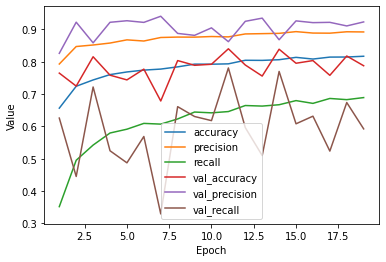

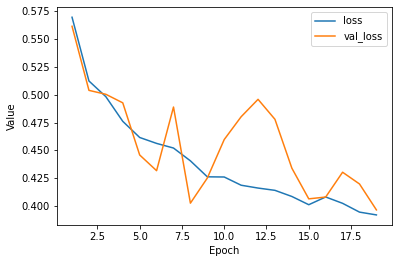

In [17]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 20
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.001
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create the model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 2

In [18]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.   
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 19, 430, 16)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 215, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 215, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 214, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 107, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 107, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 106, 64)       

351/351 [==============================] - 15s 44ms/step - loss: 0.3942 - accuracy: 0.8202 - precision: 0.8894 - recall: 0.6998 - val_loss: 0.4333 - val_accuracy: 0.8613 - val_precision: 0.8958 - val_recall: 0.7937
Epoch 29/100
351/351 [==============================] - 16s 44ms/step - loss: 0.3930 - accuracy: 0.8299 - precision: 0.8968 - recall: 0.7160 - val_loss: 0.3763 - val_accuracy: 0.8530 - val_precision: 0.9244 - val_recall: 0.7446
Epoch 30/100
351/351 [==============================] - 16s 45ms/step - loss: 0.3927 - accuracy: 0.8257 - precision: 0.8971 - recall: 0.7054 - val_loss: 0.3791 - val_accuracy: 0.8270 - val_precision: 0.9431 - val_recall: 0.6680
Epoch 31/100
351/351 [==============================] - 16s 45ms/step - loss: 0.3921 - accuracy: 0.8264 - precision: 0.8922 - recall: 0.7121 - val_loss: 0.3875 - val_accuracy: 0.8489 - val_precision: 0.9154 - val_recall: 0.7436
Epoch 32/100
351/351 [==============================] - 16s 45ms/step - loss: 0.3915 - accuracy: 0.82

Epoch 64/100
351/351 [==============================] - 18s 51ms/step - loss: 0.3684 - accuracy: 0.8451 - precision: 0.9018 - recall: 0.7477 - val_loss: 0.4278 - val_accuracy: 0.8644 - val_precision: 0.8815 - val_recall: 0.8183
Epoch 65/100
351/351 [==============================] - 15s 44ms/step - loss: 0.3673 - accuracy: 0.8427 - precision: 0.8979 - recall: 0.7460 - val_loss: 0.5319 - val_accuracy: 0.8503 - val_precision: 0.7899 - val_recall: 0.9234
Epoch 66/100
351/351 [==============================] - 18s 52ms/step - loss: 0.3647 - accuracy: 0.8465 - precision: 0.8996 - recall: 0.7534 - val_loss: 0.4227 - val_accuracy: 0.8672 - val_precision: 0.8452 - val_recall: 0.8743
Epoch 67/100
351/351 [==============================] - 18s 50ms/step - loss: 0.3693 - accuracy: 0.8452 - precision: 0.8969 - recall: 0.7531 - val_loss: 0.5076 - val_accuracy: 0.8403 - val_precision: 0.7783 - val_recall: 0.9175
Epoch 68/100
351/351 [==============================] - 16s 46ms/step - loss: 0.3646 - a

Epoch 100/100
351/351 [==============================] - 29s 84ms/step - loss: 0.3560 - accuracy: 0.8535 - precision: 0.8975 - recall: 0.7726 - val_loss: 0.4223 - val_accuracy: 0.8663 - val_precision: 0.8516 - val_recall: 0.8625
Training Performance
---------------------------------
loss:  0.3932745158672333
accuracy:  0.8873544931411743
precision:  0.8696591258049011
recall:  0.8908286094665527

Validation Performance
---------------------------------
loss:  0.42233261466026306
accuracy:  0.8662711381912231
precision:  0.8516004085540771
recall:  0.8624754548072815


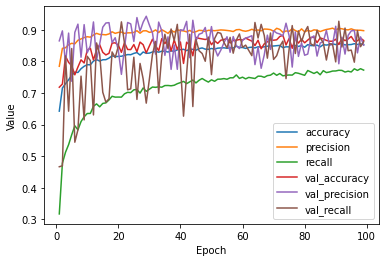

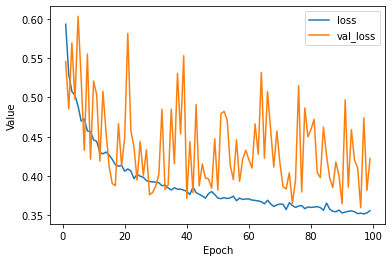

In [19]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.01
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 3

In [20]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.   
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 19, 430, 16)       80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 215, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 215, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 214, 32)        2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 107, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 107, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 106, 64)       

351/351 [==============================] - 33s 94ms/step - loss: 0.4551 - accuracy: 0.7801 - precision: 0.8571 - recall: 0.6314 - val_loss: 0.4851 - val_accuracy: 0.7453 - val_precision: 0.9182 - val_recall: 0.4961
Epoch 29/100
351/351 [==============================] - 31s 90ms/step - loss: 0.4458 - accuracy: 0.7860 - precision: 0.8620 - recall: 0.6418 - val_loss: 0.4984 - val_accuracy: 0.7932 - val_precision: 0.8833 - val_recall: 0.6395
Epoch 30/100
351/351 [==============================] - 29s 82ms/step - loss: 0.4445 - accuracy: 0.7866 - precision: 0.8668 - recall: 0.6383 - val_loss: 0.4779 - val_accuracy: 0.8092 - val_precision: 0.8937 - val_recall: 0.6690
Epoch 31/100
351/351 [==============================] - 31s 90ms/step - loss: 0.4461 - accuracy: 0.7877 - precision: 0.8559 - recall: 0.6526 - val_loss: 0.4805 - val_accuracy: 0.7344 - val_precision: 0.9308 - val_recall: 0.4627
Epoch 32/100
351/351 [==============================] - 32s 90ms/step - loss: 0.4425 - accuracy: 0.79

Epoch 64/100
351/351 [==============================] - 29s 82ms/step - loss: 0.4227 - accuracy: 0.8061 - precision: 0.8752 - recall: 0.6791 - val_loss: 0.4929 - val_accuracy: 0.7946 - val_precision: 0.9152 - val_recall: 0.6149
Epoch 65/100
351/351 [==============================] - 37s 106ms/step - loss: 0.4226 - accuracy: 0.8051 - precision: 0.8717 - recall: 0.6801 - val_loss: 0.5156 - val_accuracy: 0.8298 - val_precision: 0.8644 - val_recall: 0.7515
Epoch 66/100
351/351 [==============================] - 28s 81ms/step - loss: 0.4217 - accuracy: 0.8089 - precision: 0.8766 - recall: 0.6848 - val_loss: 0.4572 - val_accuracy: 0.7992 - val_precision: 0.9152 - val_recall: 0.6257
Epoch 67/100
351/351 [==============================] - 28s 80ms/step - loss: 0.4259 - accuracy: 0.8052 - precision: 0.8751 - recall: 0.6769 - val_loss: 0.4895 - val_accuracy: 0.8097 - val_precision: 0.9023 - val_recall: 0.6621
Epoch 68/100
351/351 [==============================] - 29s 83ms/step - loss: 0.4204 - 

Epoch 100/100
351/351 [==============================] - 33s 94ms/step - loss: 0.4169 - accuracy: 0.8159 - precision: 0.8863 - recall: 0.6922 - val_loss: 0.5126 - val_accuracy: 0.7590 - val_precision: 0.9195 - val_recall: 0.5275
Training Performance
---------------------------------
loss:  0.5060581564903259
accuracy:  0.7654644846916199
precision:  0.9167357087135315
recall:  0.5441357493400574

Validation Performance
---------------------------------
loss:  0.5125579833984375
accuracy:  0.7590141296386719
precision:  0.9195205569267273
recall:  0.5275049209594727


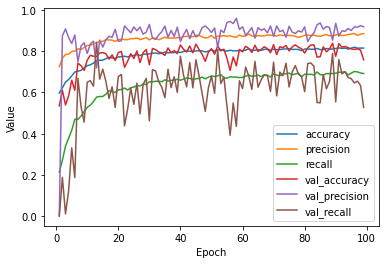

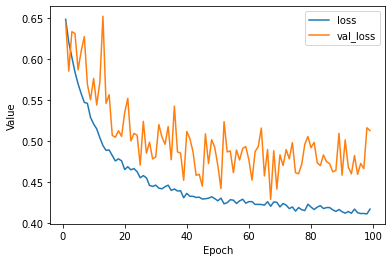

In [21]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.01
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create Model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 4

In [22]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 19, 430, 16)       80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 215, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 215, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 214, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 107, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 107, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 106, 64)       

351/351 [==============================] - 34s 98ms/step - loss: 0.4741 - accuracy: 0.7762 - precision: 0.8572 - recall: 0.6213 - val_loss: 0.5000 - val_accuracy: 0.7549 - val_precision: 0.9212 - val_recall: 0.5167
Epoch 29/100
351/351 [==============================] - 33s 95ms/step - loss: 0.4716 - accuracy: 0.7820 - precision: 0.8606 - recall: 0.6329 - val_loss: 0.5068 - val_accuracy: 0.8042 - val_precision: 0.8742 - val_recall: 0.6758
Epoch 30/100
351/351 [==============================] - 34s 96ms/step - loss: 0.4740 - accuracy: 0.7778 - precision: 0.8596 - recall: 0.6231 - val_loss: 0.4972 - val_accuracy: 0.7549 - val_precision: 0.9242 - val_recall: 0.5147
Epoch 31/100
351/351 [==============================] - 34s 96ms/step - loss: 0.4694 - accuracy: 0.7770 - precision: 0.8622 - recall: 0.6184 - val_loss: 0.5365 - val_accuracy: 0.8220 - val_precision: 0.8560 - val_recall: 0.7417
Epoch 32/100
351/351 [==============================] - 34s 96ms/step - loss: 0.4674 - accuracy: 0.78

Epoch 64/100
351/351 [==============================] - 31s 88ms/step - loss: 0.4510 - accuracy: 0.7996 - precision: 0.8665 - recall: 0.6717 - val_loss: 0.4893 - val_accuracy: 0.7996 - val_precision: 0.9083 - val_recall: 0.6326
Epoch 65/100
351/351 [==============================] - 31s 88ms/step - loss: 0.4549 - accuracy: 0.7962 - precision: 0.8687 - recall: 0.6607 - val_loss: 0.5093 - val_accuracy: 0.8110 - val_precision: 0.8943 - val_recall: 0.6729
Epoch 66/100
351/351 [==============================] - 31s 90ms/step - loss: 0.4518 - accuracy: 0.7956 - precision: 0.8650 - recall: 0.6631 - val_loss: 0.4708 - val_accuracy: 0.7919 - val_precision: 0.9157 - val_recall: 0.6081
Epoch 67/100
351/351 [==============================] - 32s 90ms/step - loss: 0.4545 - accuracy: 0.7978 - precision: 0.8677 - recall: 0.6658 - val_loss: 0.4673 - val_accuracy: 0.7859 - val_precision: 0.9019 - val_recall: 0.6051
Epoch 68/100
351/351 [==============================] - 32s 92ms/step - loss: 0.4488 - a

Epoch 100/100
351/351 [==============================] - 38s 108ms/step - loss: 0.4404 - accuracy: 0.8095 - precision: 0.8738 - recall: 0.6892 - val_loss: 0.4748 - val_accuracy: 0.8170 - val_precision: 0.9175 - val_recall: 0.6660
Training Performance
---------------------------------
loss:  0.4608924388885498
accuracy:  0.8104314208030701
precision:  0.904505729675293
recall:  0.6614211797714233

Validation Performance
---------------------------------
loss:  0.4747816026210785
accuracy:  0.8169785737991333
precision:  0.9174560308456421
recall:  0.6660118103027344


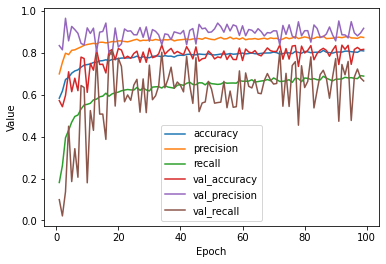

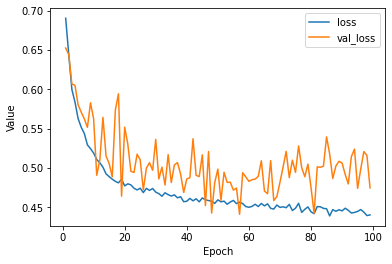

In [23]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.1
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 5

In [24]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=200, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [ ]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.1
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 19, 430, 16)       80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 215, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9, 215, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 214, 32)        2080      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 107, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 107, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 106, 64)       

351/351 [==============================] - 36s 101ms/step - loss: 0.5004 - accuracy: 0.7789 - precision: 0.8685 - recall: 0.6172 - val_loss: 0.4987 - val_accuracy: 0.7855 - val_precision: 0.9018 - val_recall: 0.6041
Epoch 29/100
351/351 [==============================] - 32s 90ms/step - loss: 0.4980 - accuracy: 0.7716 - precision: 0.8533 - recall: 0.6135 - val_loss: 0.5114 - val_accuracy: 0.7832 - val_precision: 0.8999 - val_recall: 0.6002
Epoch 30/100
351/351 [==============================] - 31s 88ms/step - loss: 0.4935 - accuracy: 0.7833 - precision: 0.8692 - recall: 0.6275 - val_loss: 0.5162 - val_accuracy: 0.7864 - val_precision: 0.9080 - val_recall: 0.6012
Epoch 31/100
351/351 [==============================] - 31s 87ms/step - loss: 0.4970 - accuracy: 0.7808 - precision: 0.8630 - recall: 0.6272 - val_loss: 0.5211 - val_accuracy: 0.7942 - val_precision: 0.9200 - val_recall: 0.6100
Epoch 32/100
351/351 [==============================] - 31s 89ms/step - loss: 0.4950 - accuracy: 0.7

Epoch 64/100
351/351 [==============================] - 33s 95ms/step - loss: 0.4857 - accuracy: 0.7905 - precision: 0.8614 - recall: 0.6538 - val_loss: 0.5015 - val_accuracy: 0.8275 - val_precision: 0.8970 - val_recall: 0.7102
Epoch 65/100
351/351 [==============================] - 32s 90ms/step - loss: 0.4830 - accuracy: 0.7951 - precision: 0.8729 - recall: 0.6538 - val_loss: 0.5589 - val_accuracy: 0.8229 - val_precision: 0.8621 - val_recall: 0.7367
Epoch 66/100
351/351 [==============================] - 34s 96ms/step - loss: 0.4870 - accuracy: 0.8003 - precision: 0.8726 - recall: 0.6671 - val_loss: 0.5038 - val_accuracy: 0.7745 - val_precision: 0.9281 - val_recall: 0.5580
Epoch 67/100
351/351 [==============================] - 32s 91ms/step - loss: 0.4826 - accuracy: 0.7989 - precision: 0.8733 - recall: 0.6629 - val_loss: 0.5206 - val_accuracy: 0.8156 - val_precision: 0.8690 - val_recall: 0.7102
Epoch 68/100
351/351 [==============================] - 32s 92ms/step - loss: 0.4775 - a

## Training 6

In [ ]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(20, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten(name='Flatten_1'))

    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=3392, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden1'))
    
    # Implements L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_lambda),
                                  name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

In [ ]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.1
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# A list of metrics to measure the performance of the model:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 20, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 20, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])